## Load data

In [2]:
%load_ext autoreload
%autoreload

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from data_utils import get_training, get_testing, HEADER
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from my_pca import my_pca

%matplotlib notebook

BENIGN_COLOR='green'
MALIGN_COLOR='orange'

# Load data
data = get_training(as_dataframe=True)
X_train = data.drop('diag', axis=1).values
y_train = data['diag'].values
N, D = X_train.shape

X_tr, y_tr = get_training()

# Show a few data points
data.head(5)

,diag,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smooth,mean_compact,mean_concav,mean_concavpt,mean_sym,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smooth,worst_compact,worst_concav,worst_concavpt,worst_sym,worst_frac
0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Look at scale of variables

<IPython.core.display.Javascript object>


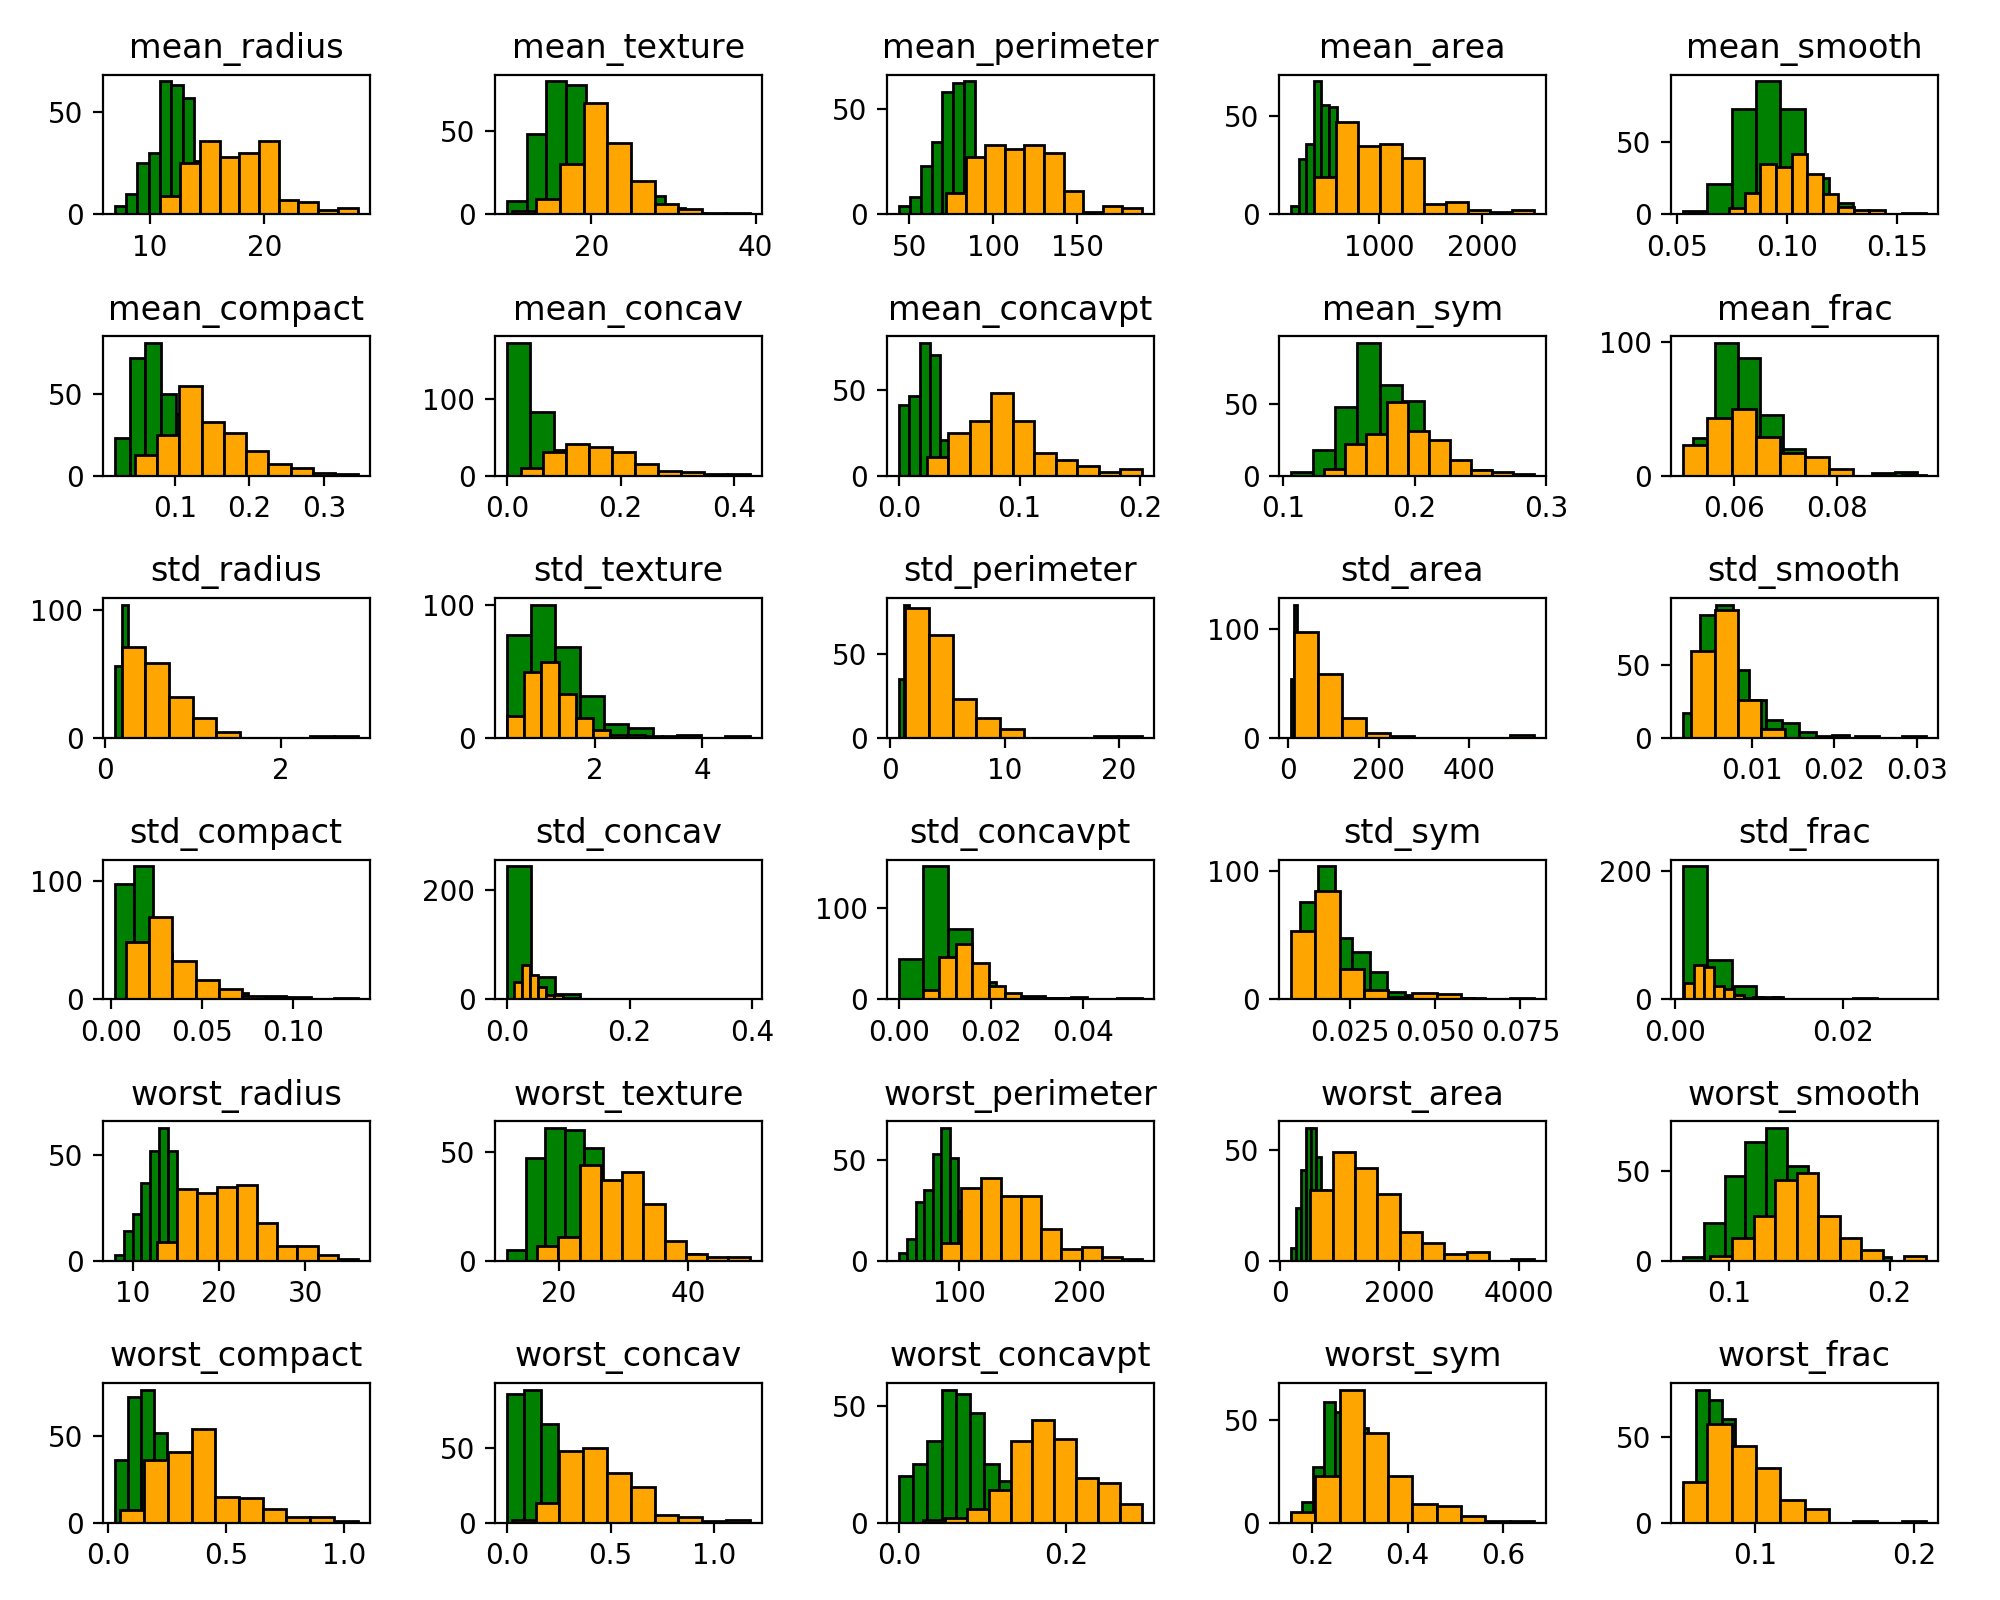

In [3]:
plt.figure(figsize=(10, 8))
diag = data.diag
for i, pred in enumerate(HEADER[1:]):
    plt.subplot(6, 5, i+1)
    plt.title(pred)
    plt.hist(data[pred][diag == 0].values, color=BENIGN_COLOR, edgecolor='black')
    plt.hist(data[pred][diag == 1].values, color=MALIGN_COLOR, edgecolor='black')
    
plt.tight_layout()

## Normalize variables

<IPython.core.display.Javascript object>


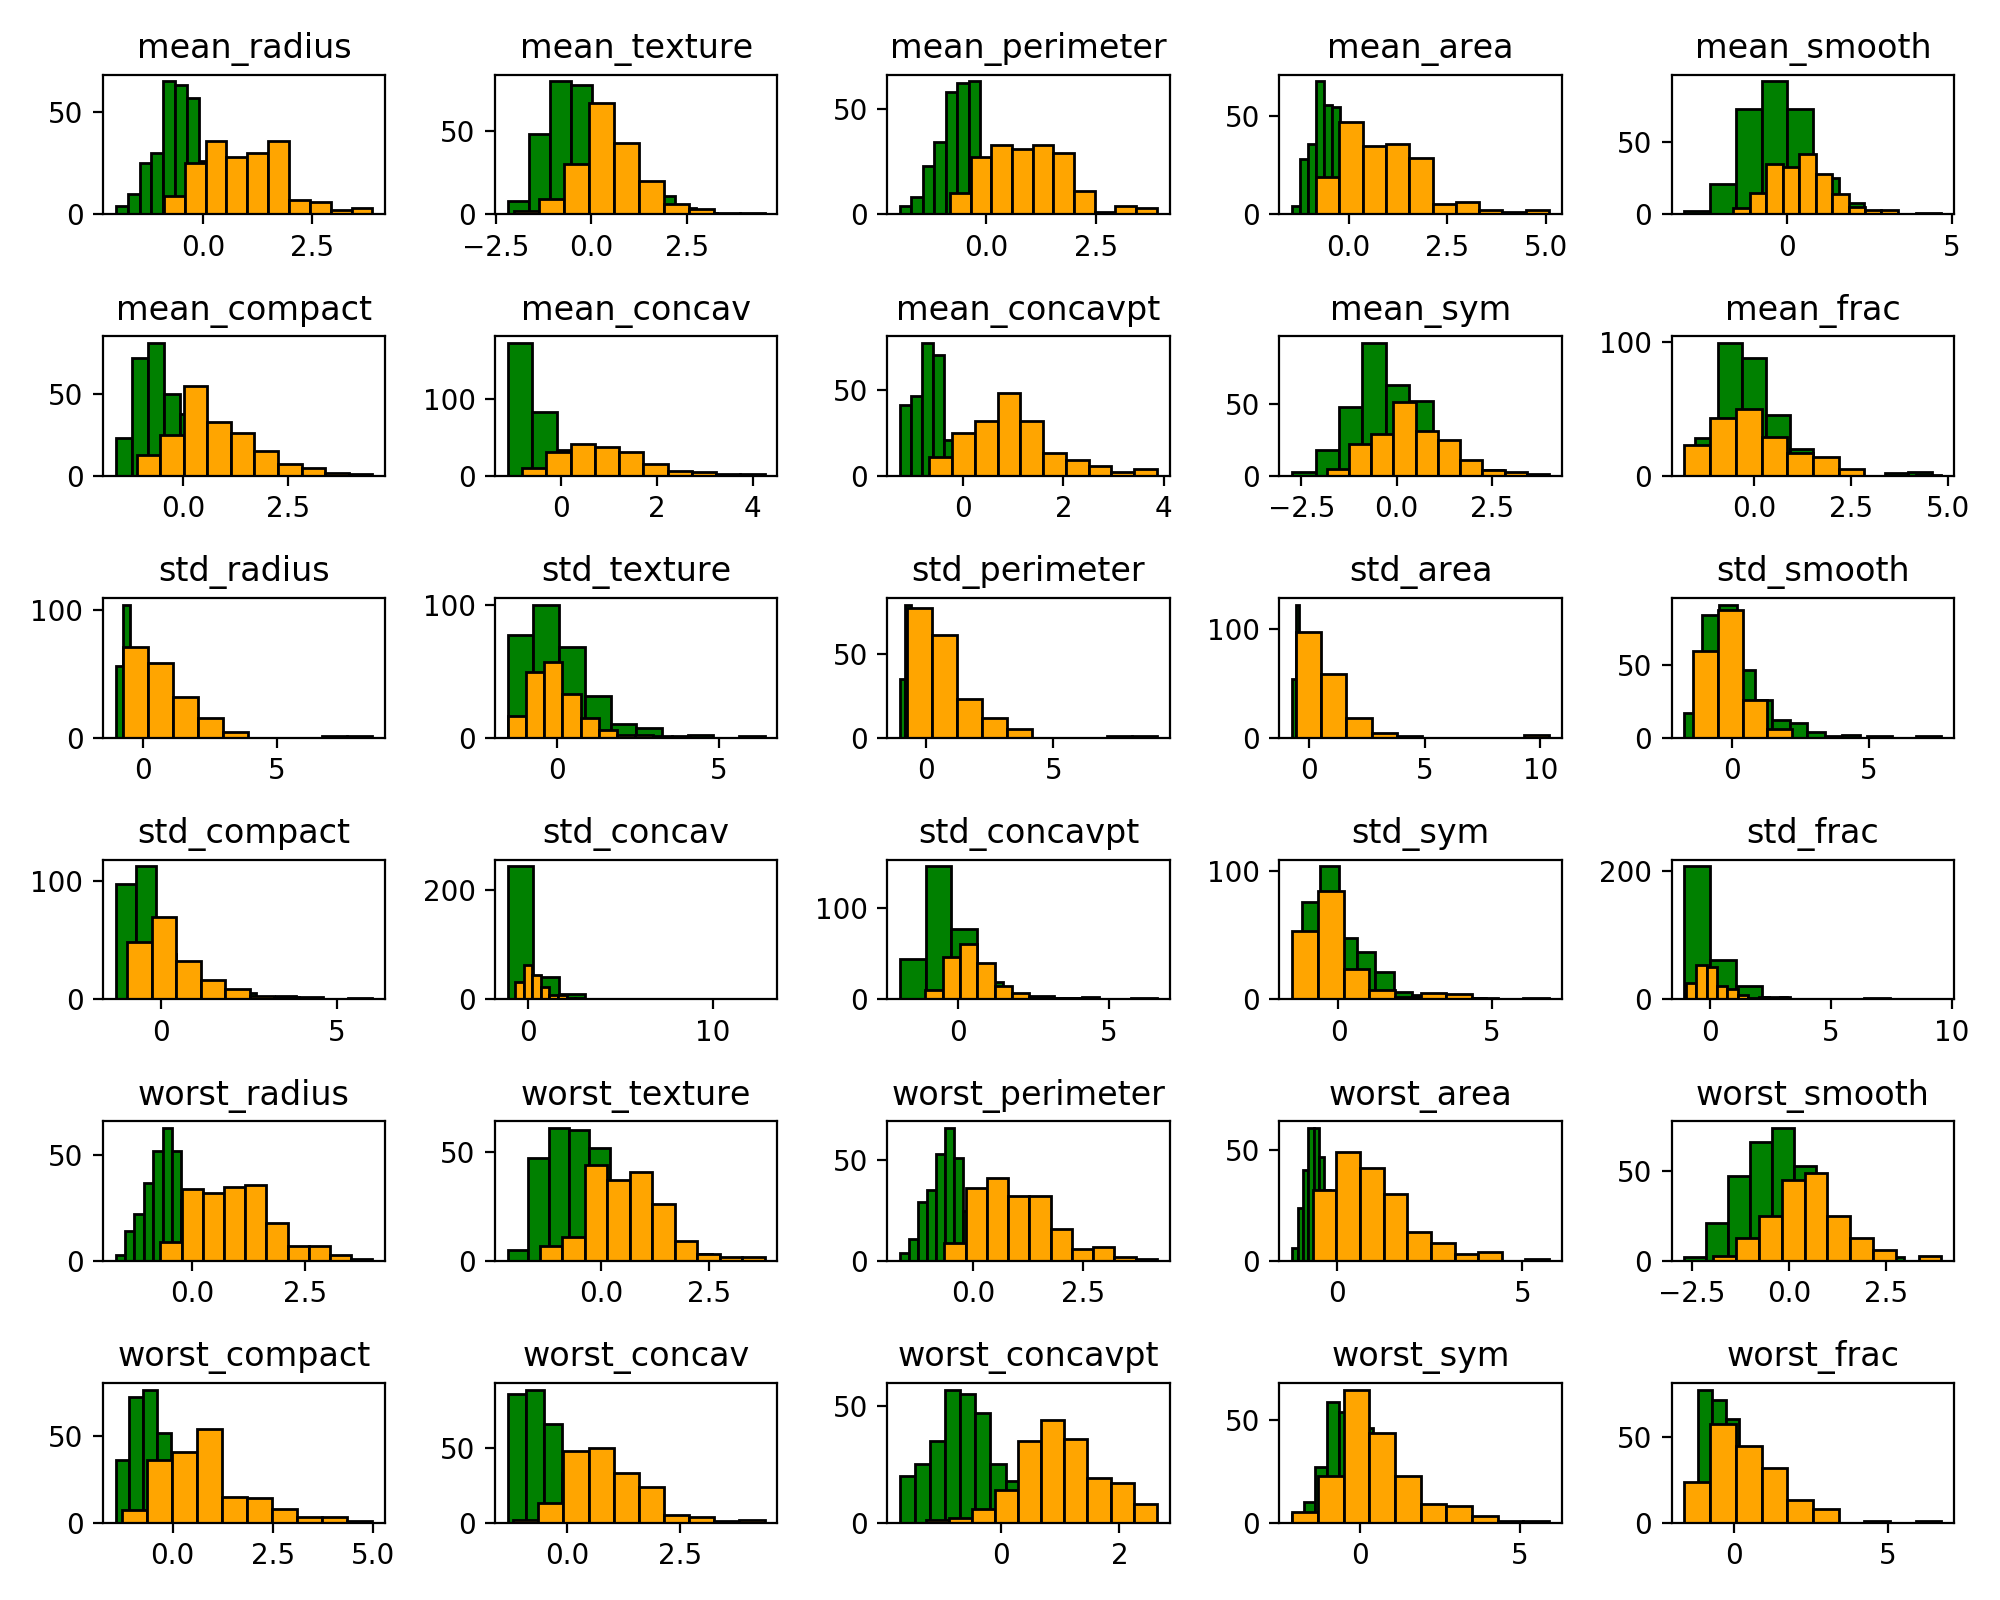

In [4]:
X_train_scaled = preprocessing.scale(X_train)
data_scaled = pd.DataFrame(X_train_scaled, columns=HEADER[1:])
data_scaled.describe()

plt.figure(figsize=(10, 8))
for i, pred in enumerate(HEADER[1:]):
    plt.subplot(6, 5, i+1)
    plt.title(pred)
    plt.hist(data_scaled[pred][diag == 0].values, color=BENIGN_COLOR, edgecolor='black')
    plt.hist(data_scaled[pred][diag == 1].values, color=MALIGN_COLOR, edgecolor='black')
    
plt.tight_layout()

## PCA

<IPython.core.display.Javascript object>


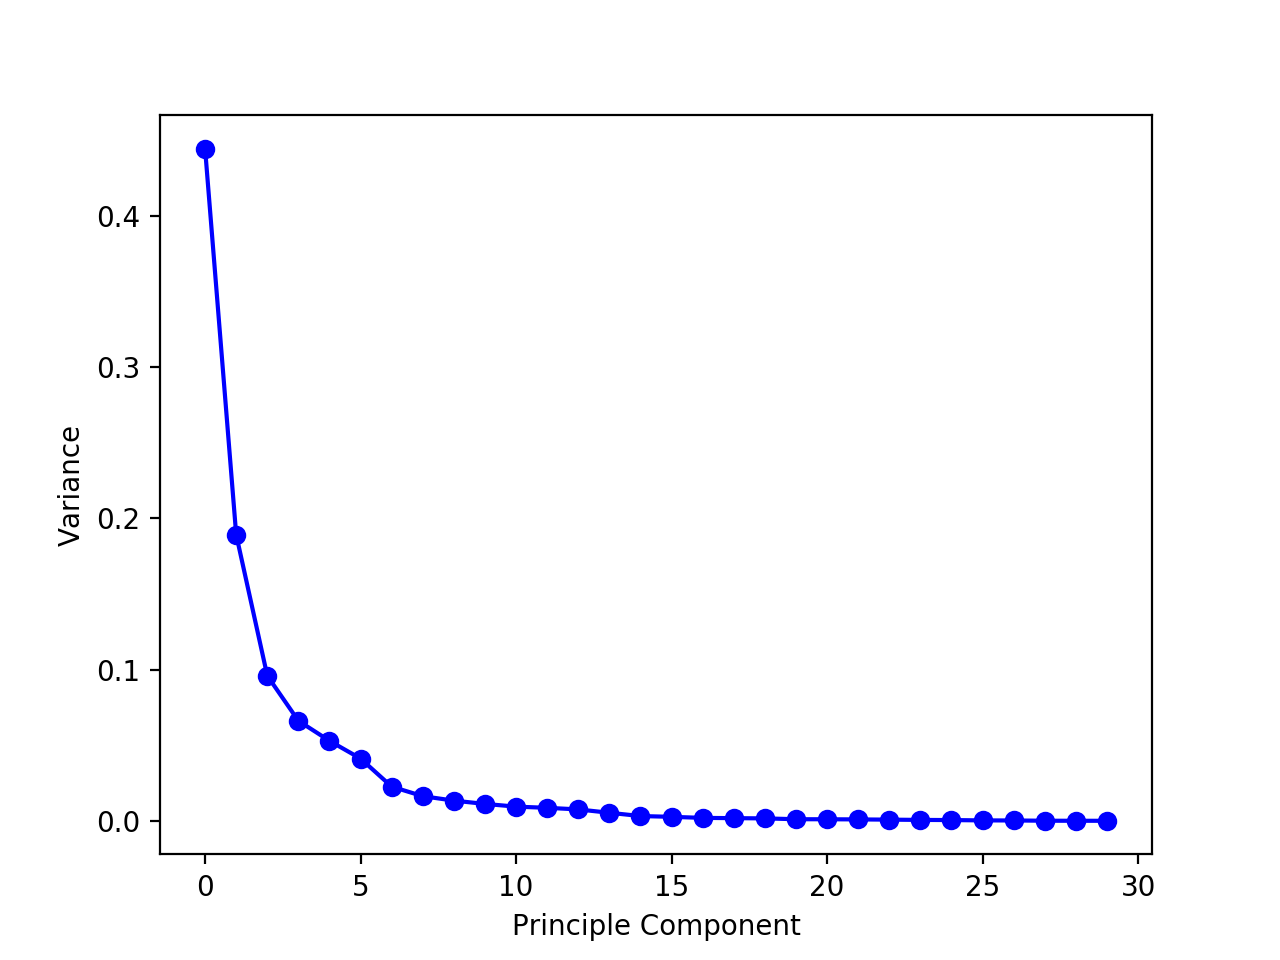

<IPython.core.display.Javascript object>


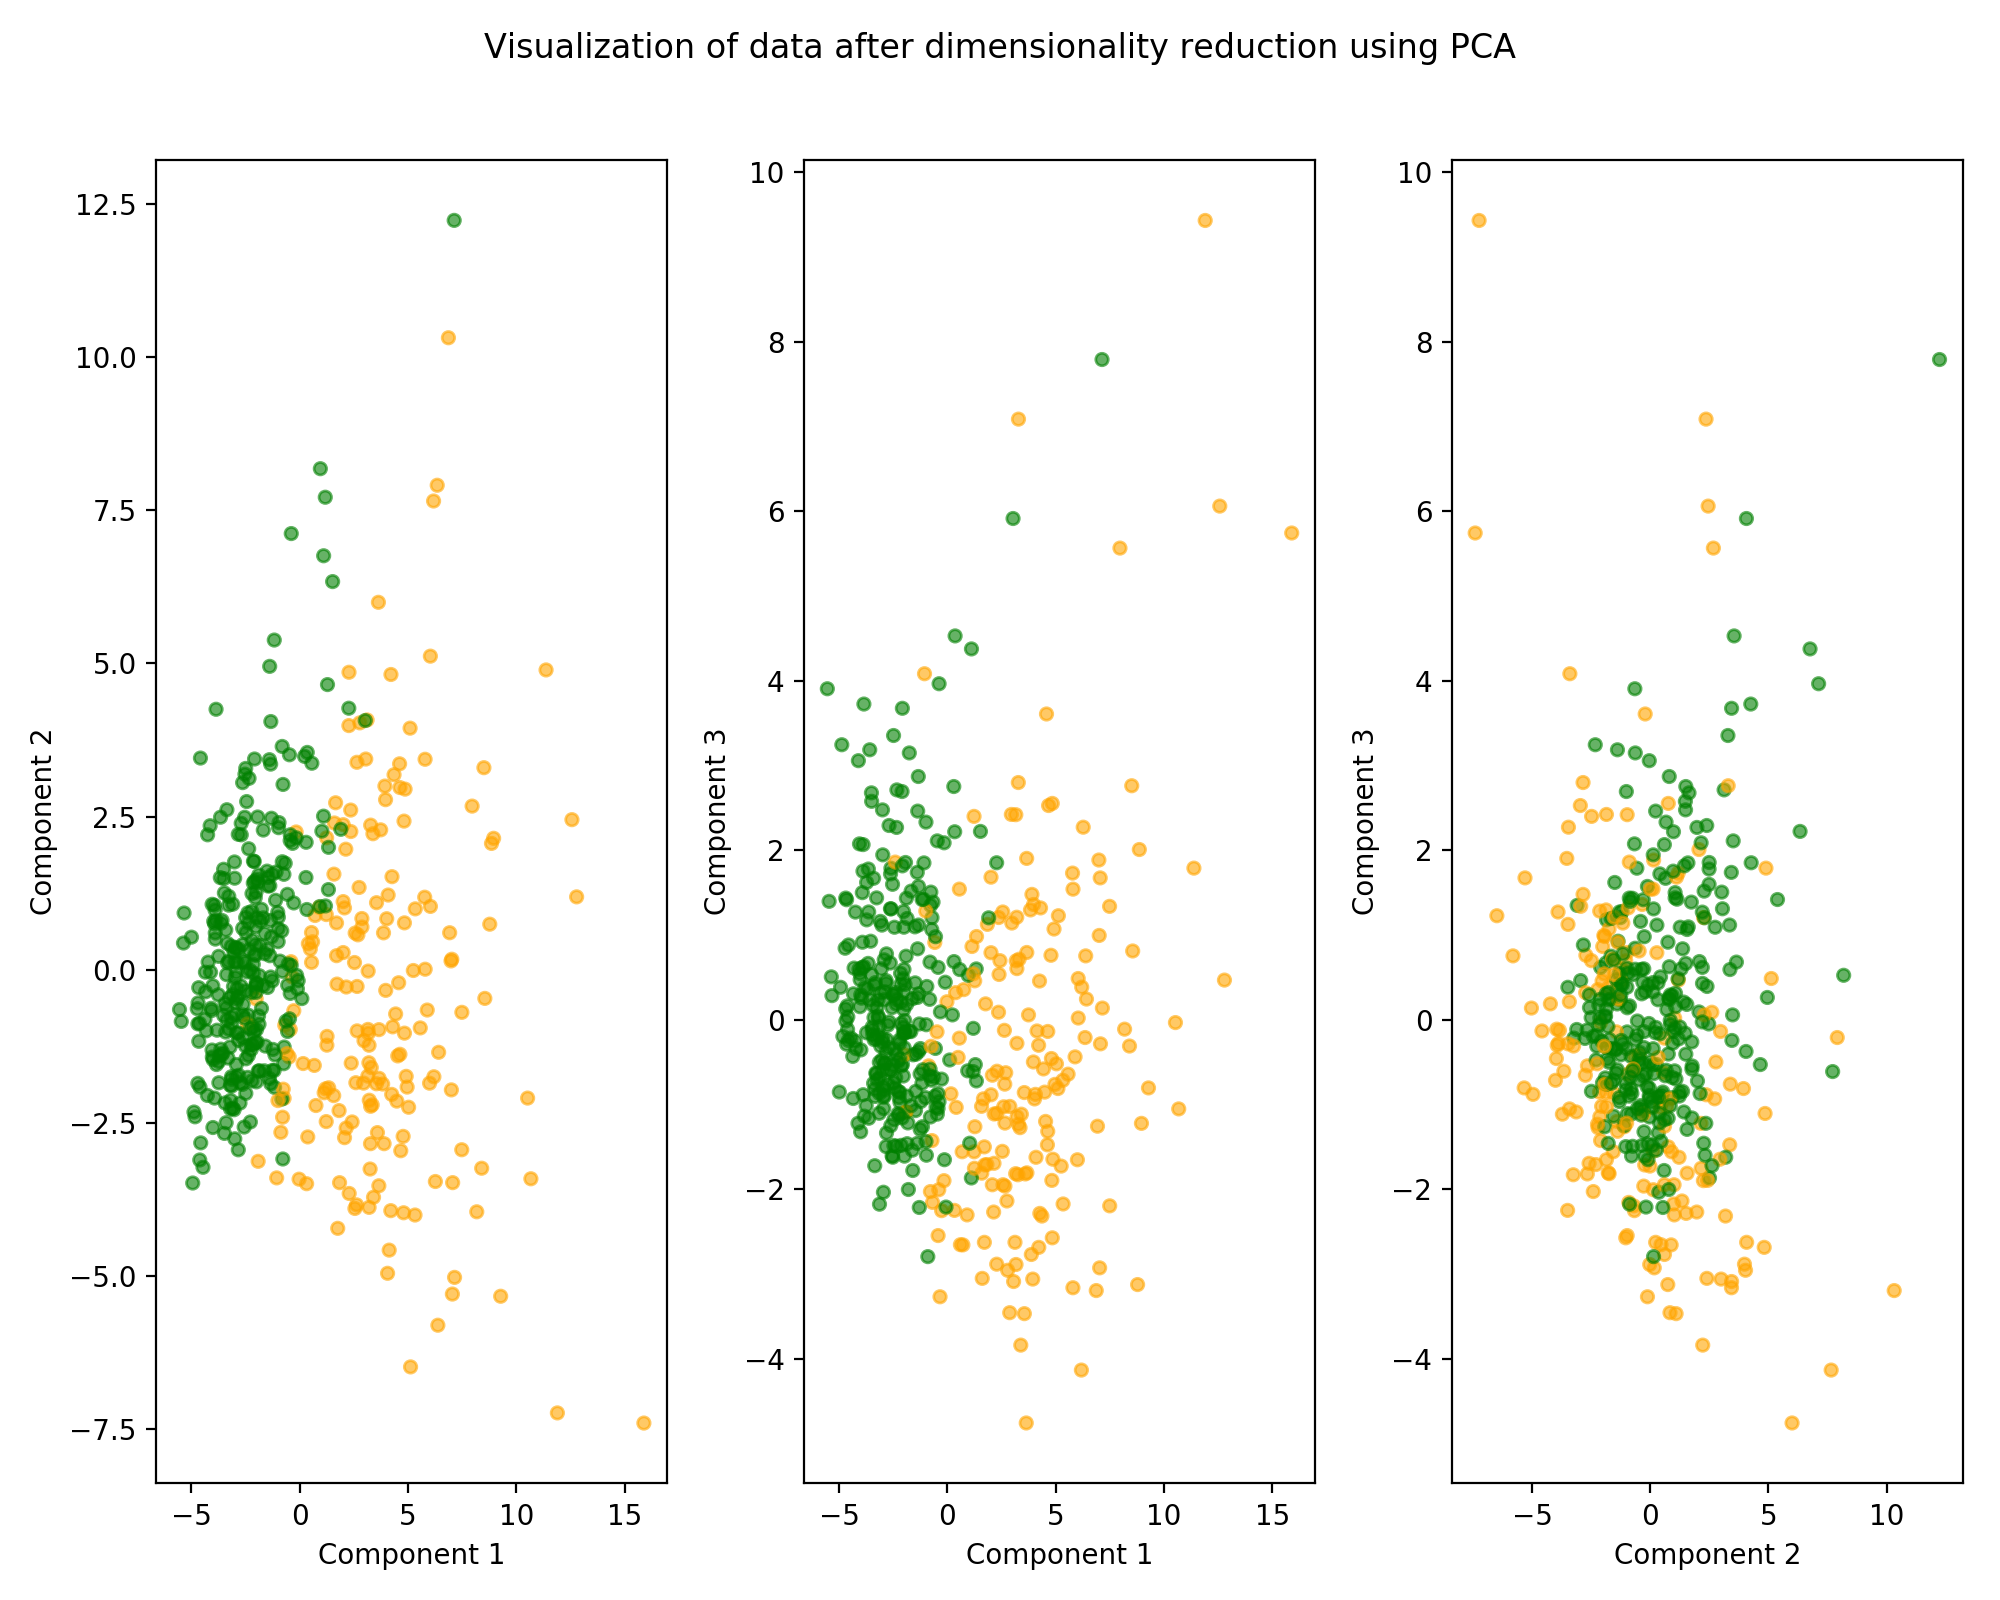

In [5]:
pca = PCA(n_components=D)
X_reduced = pca.fit_transform(X_train_scaled)
variances = pca.explained_variance_ratio_

plt.figure()
plt.plot(variances, 'bo-')
plt.xlabel('Principle Component')
plt.ylabel('Variance')

label_colors = map(lambda x: BENIGN_COLOR if x == 0 else MALIGN_COLOR, y_train)

plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=label_colors, s=20, alpha=0.6)
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1, 3, 2)
plt.scatter(X_reduced[:, 0], X_reduced[:, 2], c=label_colors, s=20, alpha=0.6)
plt.xlabel('Component 1')
plt.ylabel('Component 3')

plt.subplot(1, 3, 3)
plt.scatter(X_reduced[:, 1], X_reduced[:, 2], c=label_colors, s=20, alpha=0.6)
plt.xlabel('Component 2')
plt.ylabel('Component 3')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Visualization of data after dimensionality reduction using PCA')


<IPython.core.display.Javascript object>


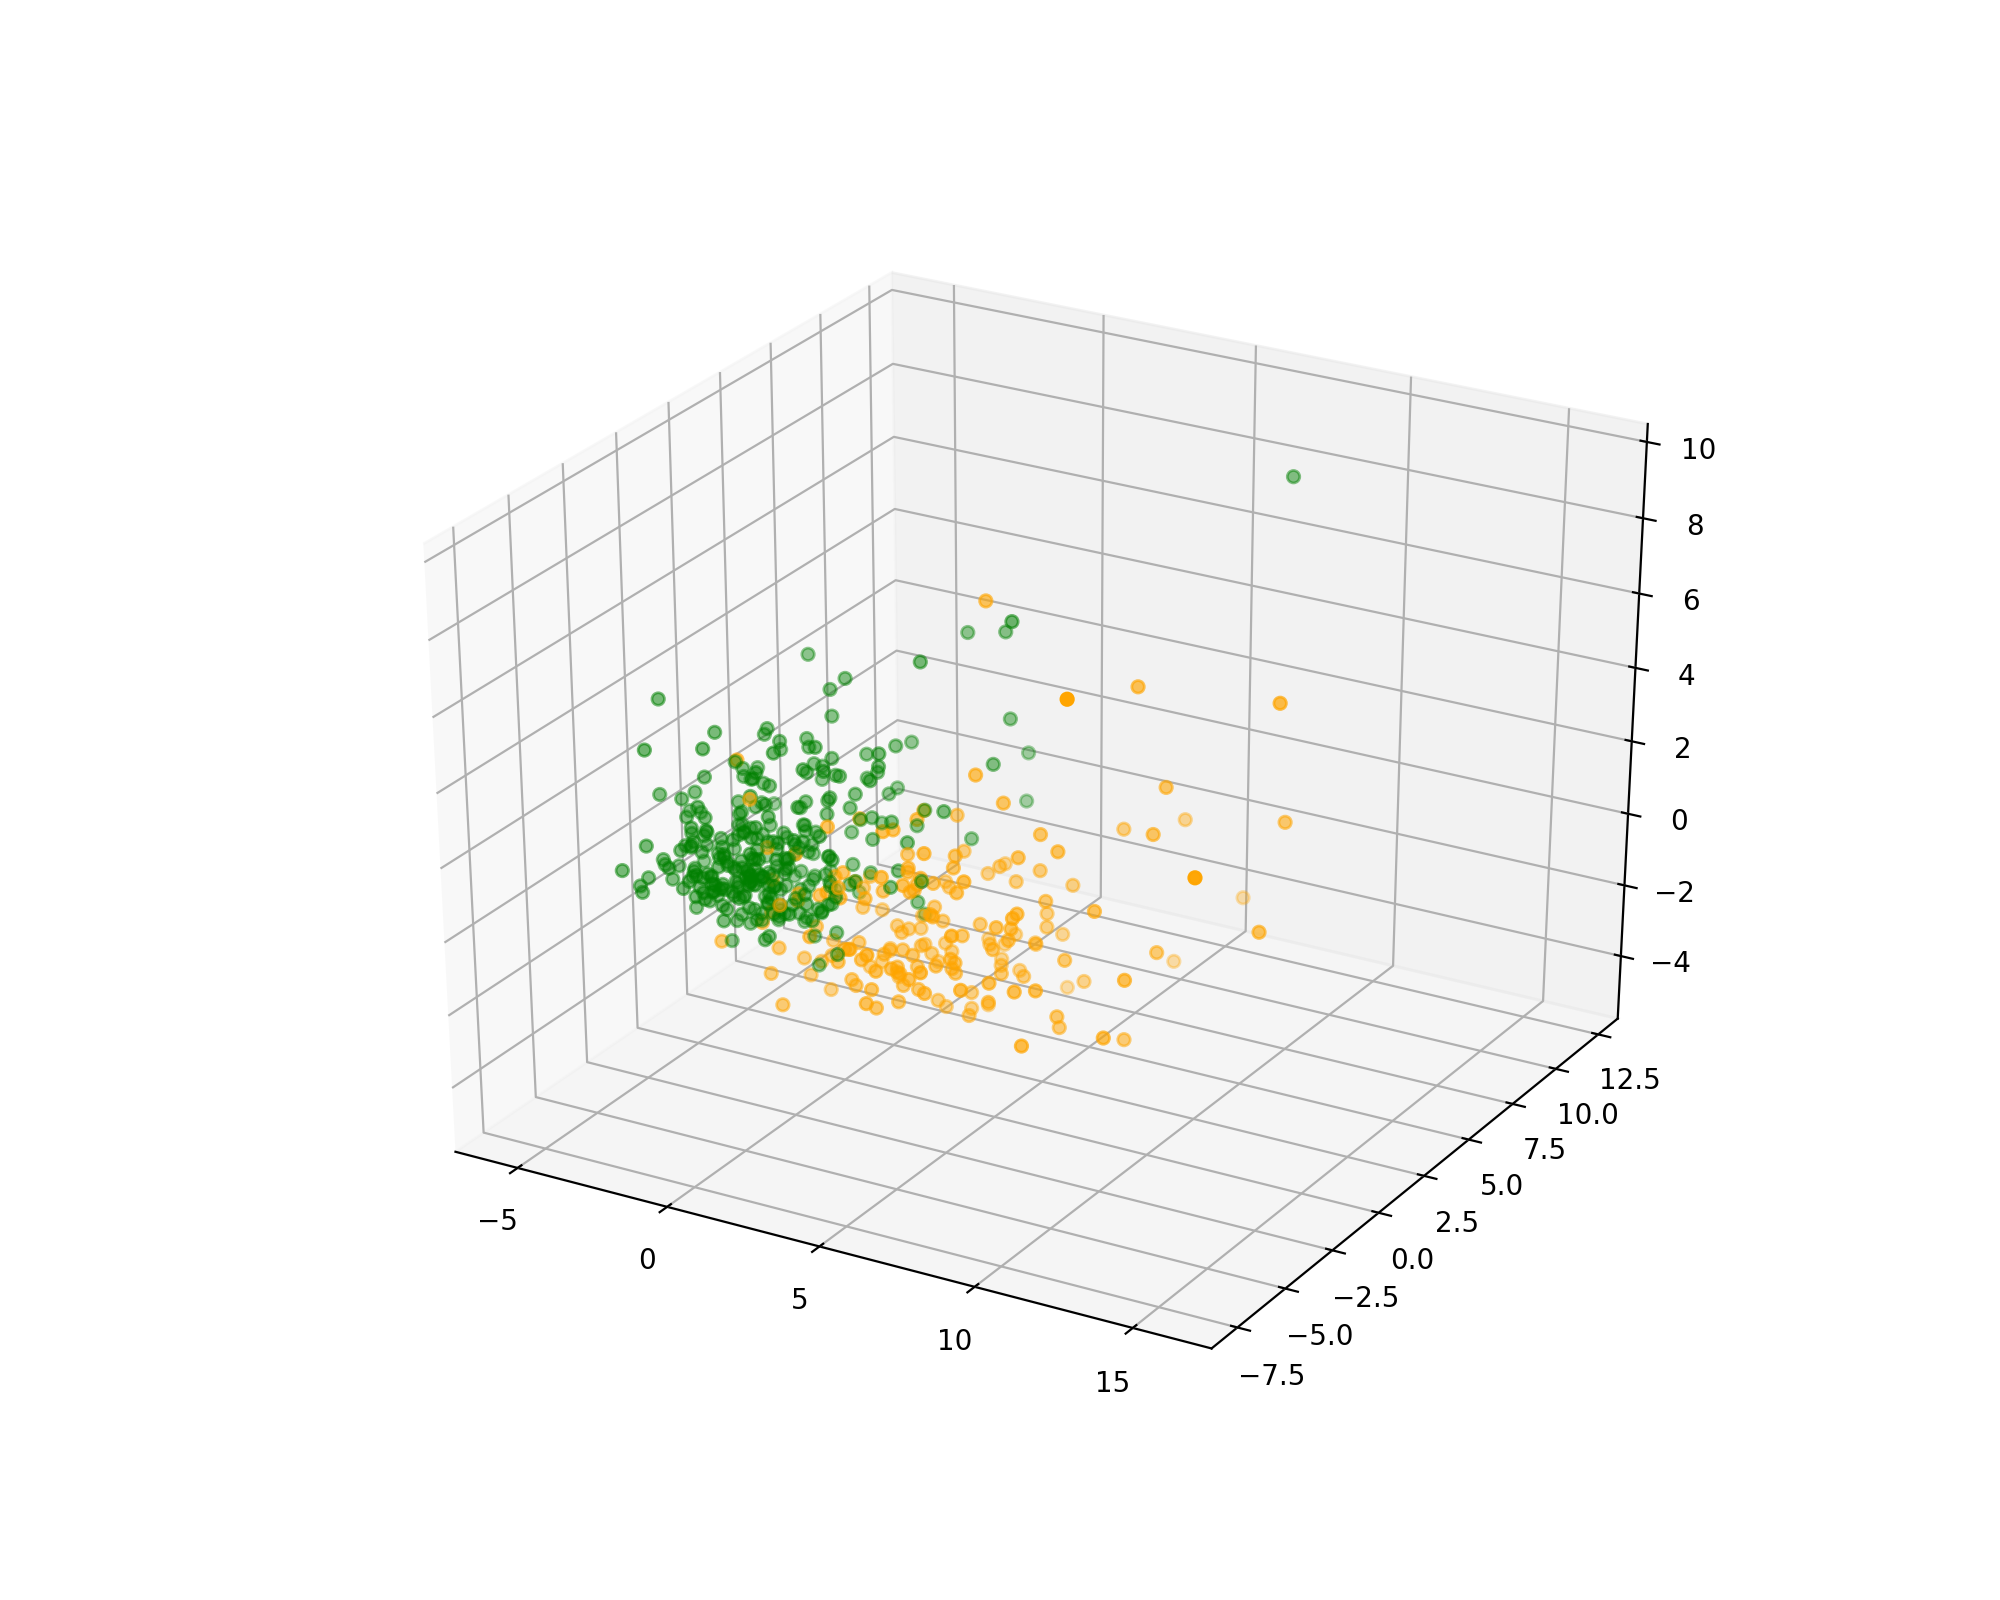

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=label_colors)

## Logistic Regression

In [7]:
# Logistic Regression
models = [('L2, C=1', LogisticRegression()),
          ('L2, C=10', LogisticRegression(C=10)),
          ('L2, C=100', LogisticRegression(C=100)),
          ('L1, C=1', LogisticRegression(penalty='l1')),
          ('L1, C=5', LogisticRegression(penalty='l1', C=5)),
          ('L1, C=10', LogisticRegression(penalty='l1', C=10))]

accs = []
best_model, best_name, best_comp, best_acc = None, None, -1, -1
for name, model in models:
    pca_accs = []
    print 'Training with', name
    for comp in range(1, D):
        acc = cross_val_score(model, X_reduced[:, 0:comp], y_train, scoring='accuracy', cv=15).mean()
        pca_accs.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_comp = comp
            best_name = name
#         print name, 'Used components:', comp, 'Val acc:', acc
    accs.append((name, pca_accs))

print 'Best model: %s Val accuracy: %.3f Used components: %d'%(best_name, best_acc, best_comp)


Training with L2, C=1
Training with L2, C=10
Training with L2, C=100
Training with L1, C=1
Training with L1, C=5
Training with L1, C=10
Best model: L2, C=1 Val accuracy: 0.981 Used components: 14


## Plot accuracies

<IPython.core.display.Javascript object>


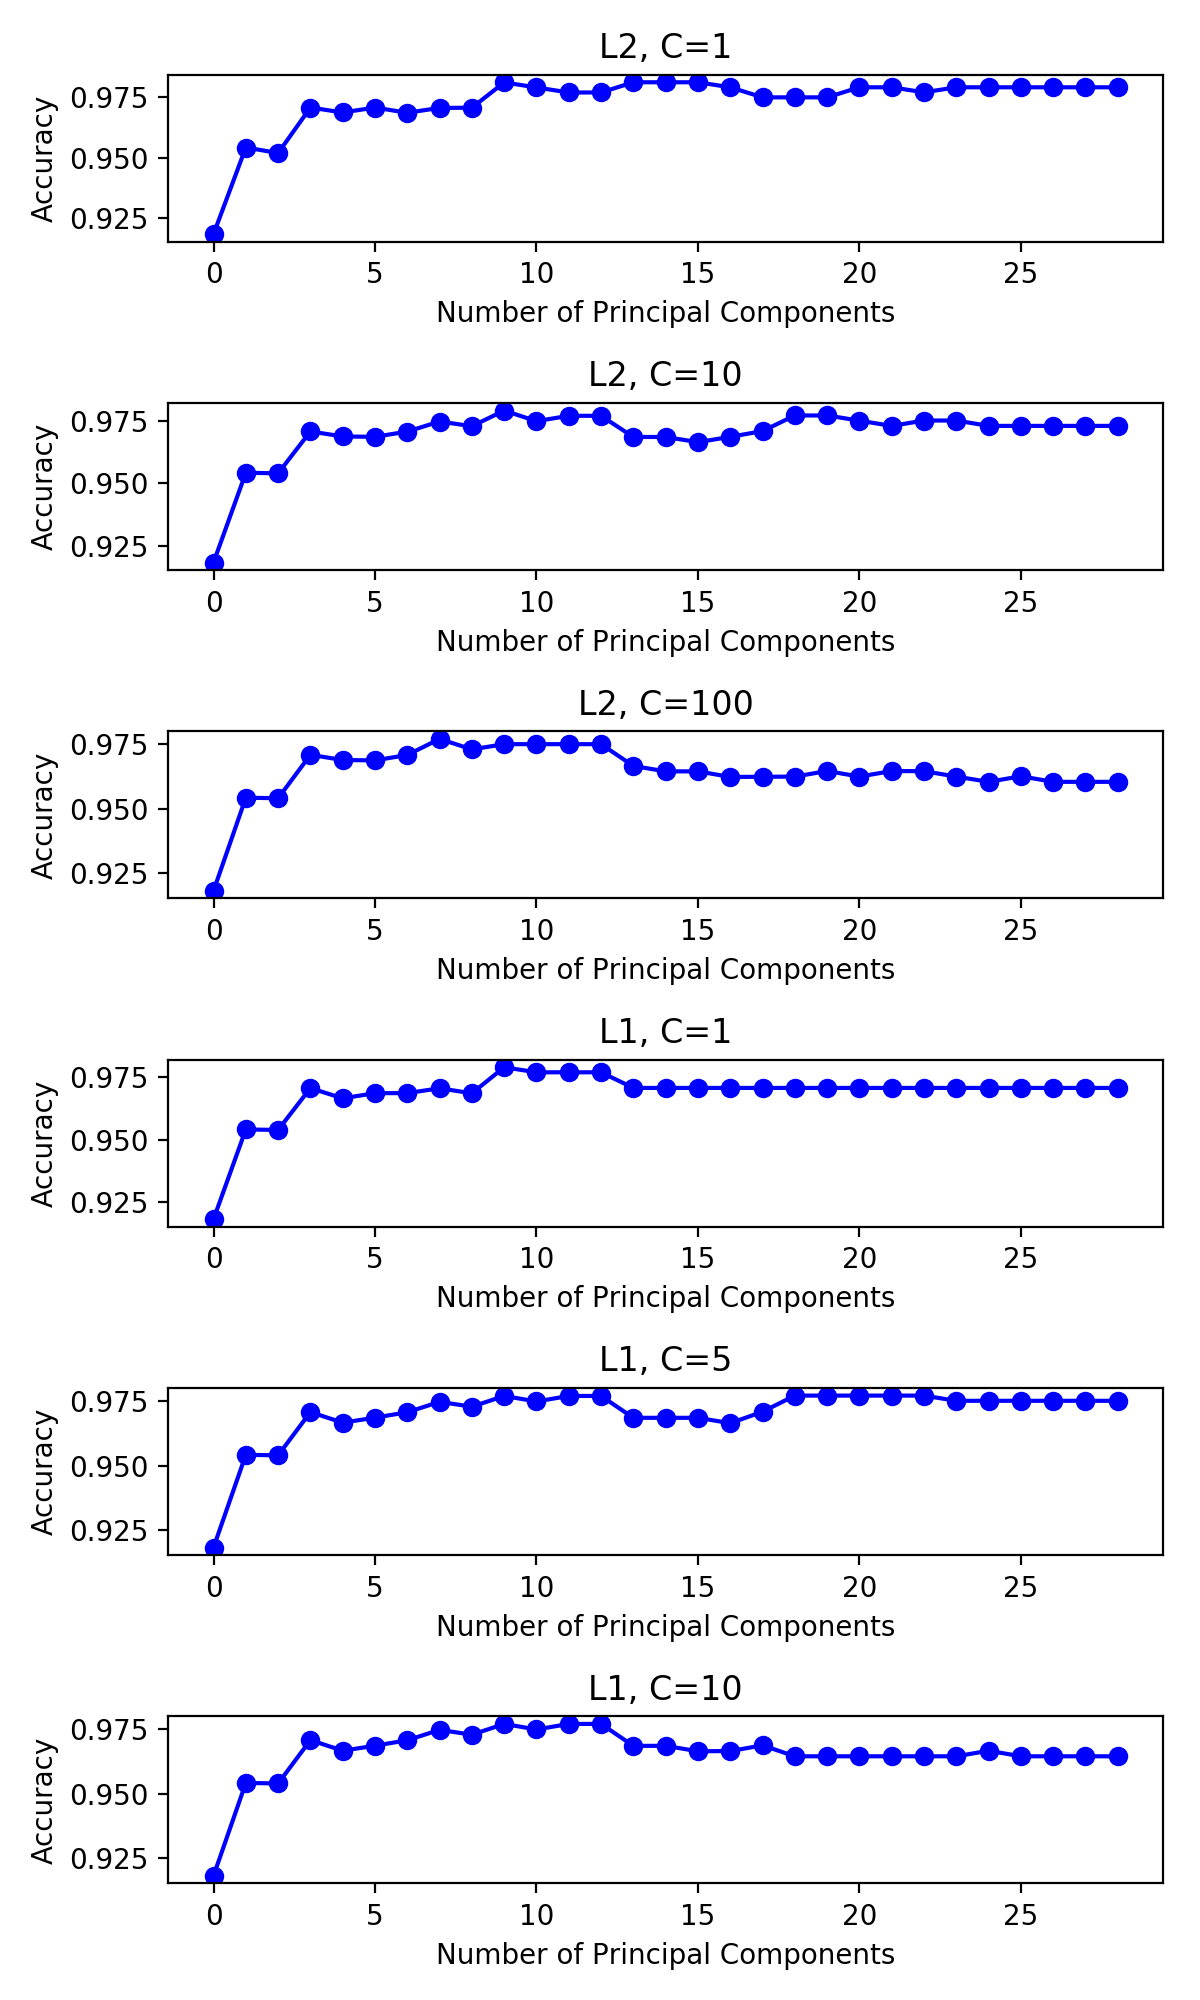

In [8]:
plt.figure(figsize=(6, 10))
for i, (name, acc) in enumerate(accs):
    plt.subplot(len(models), 1, i+1)
    plt.plot(acc, 'bo-')
    plt.title(name)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Accuracy')
        
plt.tight_layout()

## Confusion matrices

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f'%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<IPython.core.display.Javascript object>


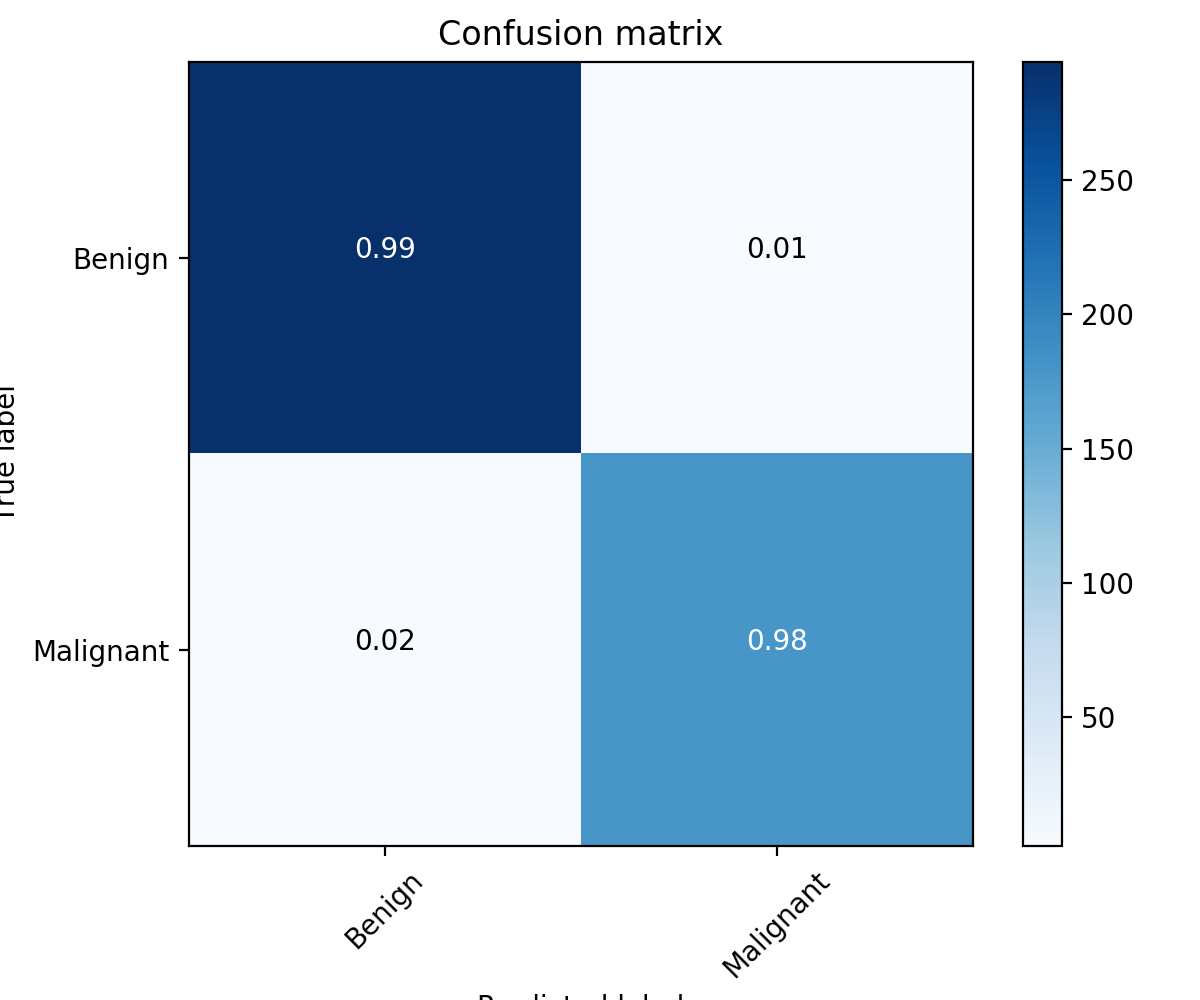

Normalized confusion matrix
[[ 0.99324324  0.00675676]
 [ 0.02197802  0.97802198]]


In [10]:
plt.figure(figsize=(6,5))

y_pred = best_model.fit(X_reduced[:, 0:best_comp], y_train).predict(X_reduced[:, 0:best_comp])
cm_pca = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(cm_pca, classes=['Benign', 'Malignant'], normalize=True)
